In [9]:
import pickle
import glob
import torch
import numpy as np

In [10]:
# Define the directory containing the pickle files
# directory_path = "/home/zep/fl_powerpropagation/outputs/2024-06-11/16-05-58/working"
# directory_path = "/home/zep/fl_powerpropagation/outputs/2024-06-11/16-19-20/working" # pp 1.25
# directory_path = "/home/zep/fl_powerpropagation/outputs/2024-06-11/18-26-01/working"
# directory_path = "/home/zep/fl_powerpropagation/outputs/2024-06-11/19-10-26/working" # pp 1.25
directory_path = "/home/zep/fl_powerpropagation/outputs/2024-06-12/08-54-52/working"

# Get a list of all pickle files
pickle_files = sorted(glob.glob(f"{directory_path}/mask_*.pickle"))

# Load the masks
masks = []
for file in pickle_files:
    with open(file, "rb") as f:
        mask = pickle.load(f)
        masks.append(mask)


# Ensure each mask is a list of numpy arrays
masks = [[np.array(layer_mask) for layer_mask in mask] for mask in masks]

In [11]:
# # Define the directory containing the .bin files
# directory_path = "/home/zep/fl_powerpropagation/outputs/2024-06-11/18-26-01/results/parameters"

# # Get a list of all .bin files
# bin_files = sorted(glob.glob(f"{directory_path}/parameters*.bin"))

# # Load the model parameters
# models = []
# for file in bin_files:
#     try:
#         # Attempt to load using torch.load
#         model_state = torch.load(file)
#         models.append(model_state)
#     except Exception as e:
#         print(f"Error loading {file}: {e}")

# # Convert model parameters to binary masks
# masks = []
# for model_state in models:
#     mask = [param != 0 for param in model_state.values()]
#     masks.append(mask)

In [12]:
# Ensure each mask is a list of numpy arrays
masks = [[np.array(layer_mask) for layer_mask in mask] for mask in masks]

In [13]:
# Function to compute overlap percentage between two masks
def compute_overlap_percentage(mask1, mask2):
    total_weights = sum(m1.size for m1 in mask1)  # Total number of weights
    overlap_weights = sum(
        np.sum(m1 & m2) for m1, m2 in zip(mask1, mask2)
    )  # Overlapping weights
    return (overlap_weights / total_weights) * 100  # Percentage of overlap


# Compute overlap percentage between consecutive masks
overlap_percentages = [
    compute_overlap_percentage(masks[i], masks[i + 1]) for i in range(len(masks) - 1)
]

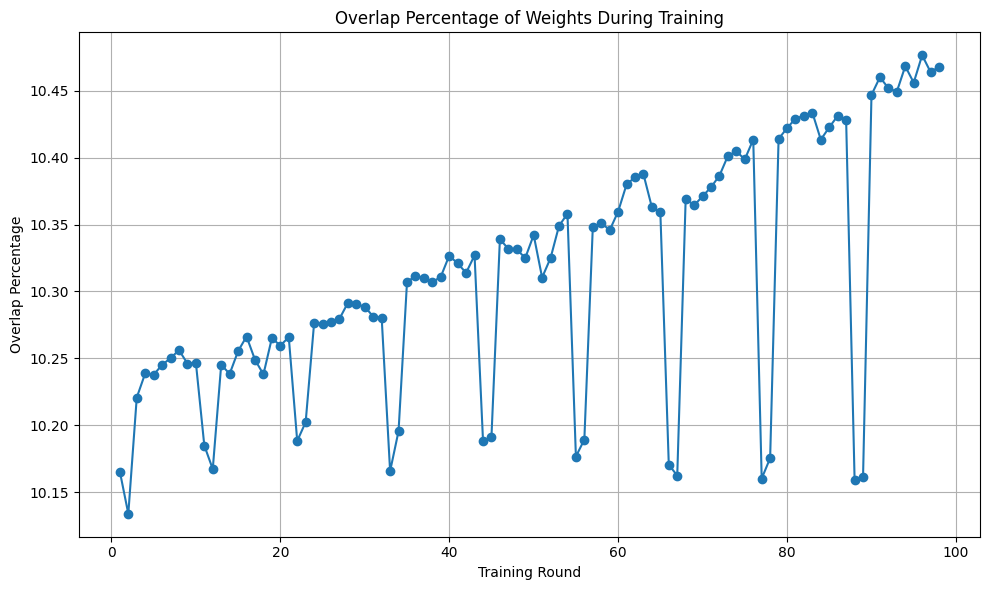

In [14]:
import matplotlib.pyplot as plt

# Plot overlap percentage over time
rounds = range(1, len(overlap_percentages) + 1)
plt.figure(figsize=(10, 6))
plt.plot(rounds, overlap_percentages, marker="o")
plt.xlabel("Training Round")
plt.ylabel("Overlap Percentage")
plt.title("Overlap Percentage of Weights During Training")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
import concurrent.futures


# Function to compute overlap percentage between two masks
def compute_overlap_percentage(mask1, mask2):
    # total_weights = sum(m1.size for m1 in mask1)  # Total number of weights
    n_mask1 = sum([np.sum(m1) for m1 in mask1])  # count number of weight for each mask
    n_mask2 = sum([np.sum(m2) for m2 in mask2])
    overlap_weights = sum(
        np.sum(m1 & m2) for m1, m2 in zip(mask1, mask2)
    )  # Overlapping weights
    return (
        100 - (overlap_weights / max(n_mask1, n_mask2)) * 100
    )  # Percentage of overlap


# Compute overlap percentage matrix
num_masks = len(masks)
overlap_matrix = np.zeros((num_masks, num_masks))


def compute_overlap(i, j):
    overlap_matrix[i, j] = compute_overlap_percentage(masks[i], masks[j])


# Use multi-threading to parallelize the computation
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for i in range(num_masks):
        for j in range(num_masks):
            futures.append(executor.submit(compute_overlap, i, j))

    # Wait for all computations to complete
    concurrent.futures.wait(futures)

# Print the overlap matrix
print(overlap_matrix)

[[0.         8.32330022 2.75135313 ... 7.9207047  8.27721432 8.41180518]
 [8.32330022 0.         8.60747979 ... 5.75624909 5.80753689 5.43634547]
 [2.75135313 8.60747979 0.         ... 8.21397716 8.54217627 8.67724501]
 ...
 [7.9207047  5.75624909 8.21397716 ... 0.         5.49466967 5.7553098 ]
 [8.27721432 5.80753689 8.54217627 ... 5.49466967 0.         5.57697876]
 [8.41180518 5.43634547 8.67724501 ... 5.7553098  5.57697876 0.        ]]


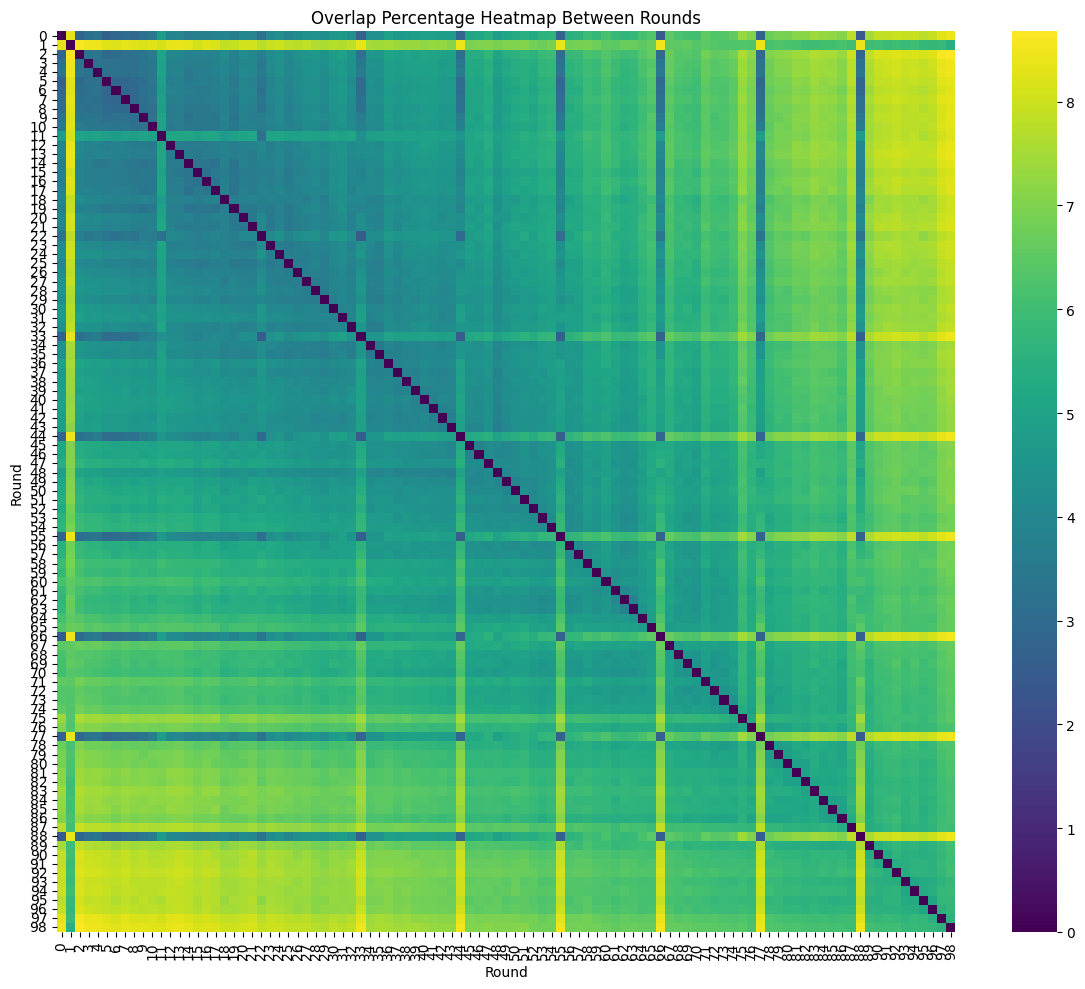

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    overlap_matrix,
    annot=False,
    fmt=".2f",
    cmap="viridis",
    xticklabels=range(num_masks),
    yticklabels=range(num_masks),
)
plt.xlabel("Round")
plt.ylabel("Round")
plt.title("Overlap Percentage Heatmap Between Rounds")
plt.tight_layout()
plt.show()